# Data Set Summary Info

This notebook provides summary information and descriptive statistics for our data sets.

## Setup

In [1]:
import sys
import re

In [2]:
from pathlib import Path

In [3]:
import itertools as it
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import plotnine as p

In [4]:
import bookgender.datatools as dt
from bookgender.nbutils import *

In [5]:
def eprint(*args):
    print(*args, file=sys.stderr)

In [6]:
fig_dir = init_figs('DataSummary')

using figure dir figures\DataSummary


In [7]:
def lbl_pct(fs):
    return ['{:.0f}%'.format(f*100) for f in fs]

Function to make plots:

## Load Data Files

Load book author gender info:

In [8]:
datasets =  sorted(list(dt.datasets.keys()))

In [9]:
book_gender = pd.read_parquet('data/author-gender.parquet')
book_gender['gender'] = book_gender['gender'].astype('category')
book_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234574 entries, 0 to 12234573
Data columns (total 2 columns):
 #   Column  Dtype   
---  ------  -----   
 0   item    int64   
 1   gender  category
dtypes: category(1), int64(1)
memory usage: 105.0 MB


In [10]:
book_gender = pd.read_csv('data/author-gender.csv.gz', dtype={'gender': 'category'})
book_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234574 entries, 0 to 12234573
Data columns (total 2 columns):
 #   Column  Dtype   
---  ------  -----   
 0   item    int64   
 1   gender  category
dtypes: category(1), int64(1)
memory usage: 105.0 MB


Book gender will be more useful if we index it.

In [11]:
book_gender = book_gender.set_index('item')

Load the Library of Congress book list:

In [12]:
loc_books = pd.read_csv('data/loc-books.csv.gz')
loc_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5267327 entries, 0 to 5267326
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   item    int64
dtypes: int64(1)
memory usage: 40.2 MB


Load rating data sets:

In [13]:
ratings = {}
for ds in datasets:
    eprint('loading ratings for', ds)
    ratings[ds] = pd.read_parquet(f'data/{ds}/ratings.parquet')

loading ratings for AZ


loading ratings for BX-E
loading ratings for BX-I
loading ratings for GR-E


loading ratings for GR-I


## Basic Data Set Stats

In [14]:
ds_summary = pd.DataFrame.from_dict(dict(
    (n, {'Users': f['user'].nunique(), 'Items': f['item'].nunique(), 'Pairs': len(f)})
    for (n, f) in ratings.items()
), orient='index')
ds_summary['Density'] = ds_summary['Pairs'] / (ds_summary['Users'] * ds_summary['Items'])
ds_summary

,Users,Items,Pairs,Density
AZ,8026324,2268142,22460535,0.000001
BX-E,77805,151670,427283,0.000036
BX-I,105283,279501,1129814,0.000038
GR-E,808782,1080777,86537566,0.000099
GR-I,870011,1096636,188943278,0.000198


In [15]:
def pct_fmt(p):
    return '{:.4f}%'.format(p * 100)
def n_fmt(n):
    return '{:,d}'.format(n)
print(ds_summary.to_latex(formatters={
    'Users': n_fmt,
    'Items': n_fmt,
    'Pairs': n_fmt,
    'Density': pct_fmt
}))

\begin{tabular}{lrrrr}
\toprule
{} &     Users &     Items &       Pairs & Density \\
\midrule
AZ   & 8,026,324 & 2,268,142 &  22,460,535 & 0.0001\% \\
BX-E &    77,805 &   151,670 &     427,283 & 0.0036\% \\
BX-I &   105,283 &   279,501 &   1,129,814 & 0.0038\% \\
GR-E &   808,782 & 1,080,777 &  86,537,566 & 0.0099\% \\
GR-I &   870,011 & 1,096,636 & 188,943,278 & 0.0198\% \\
\bottomrule
\end{tabular}



### Distributions

What is the rating distribution for explicit-feedback data sets?

In [16]:
exp_re = re.compile(r'^\w\w(-E|$)')
[ds for ds in ratings.keys() if exp_re.match(ds)]

['AZ', 'BX-E', 'GR-E']

In [17]:
exp_rate_stats = pd.concat(
    (rates.groupby('rating').item.count().reset_index(name='count').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
exp_rate_stats.head()

,rating,count,Set
0,1.0,1115069,AZ
1,1.5,254,AZ
2,2.0,976839,AZ
3,2.5,453,AZ
4,3.0,1918050,AZ


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


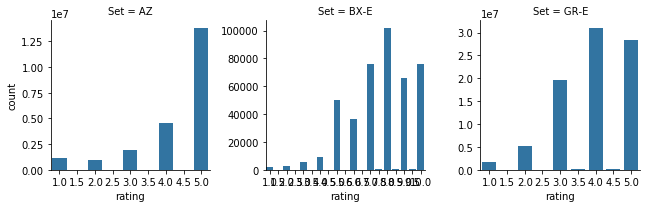

In [18]:
grid = sns.FacetGrid(col='Set', data=exp_rate_stats, sharex=False, sharey=False)
grid.map(sns.barplot, 'rating', 'count')

In [19]:
user_means = pd.concat(
    (rates.groupby('user').rating.mean().reset_index(name='AvgRating').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
user_means.head()

,user,AvgRating,Set
0,1,5.000000,AZ
1,2,5.000000,AZ
2,3,5.000000,AZ
3,4,4.666667,AZ
4,5,4.000000,AZ


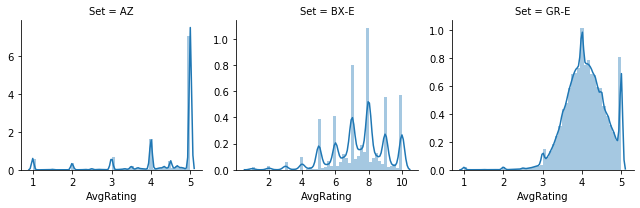

In [20]:
grid = sns.FacetGrid(col='Set', data=user_means, sharey=False, sharex=False)
grid.map(sns.distplot, 'AvgRating')

In [21]:
item_means = pd.concat(
    (rates.groupby('item').rating.mean().reset_index(name='AvgRating').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
item_means.head()

,item,AvgRating,Set
0,0,4.250000,AZ
1,2,4.523077,AZ
2,5,4.348315,AZ
3,8,4.368421,AZ
4,11,3.968750,AZ


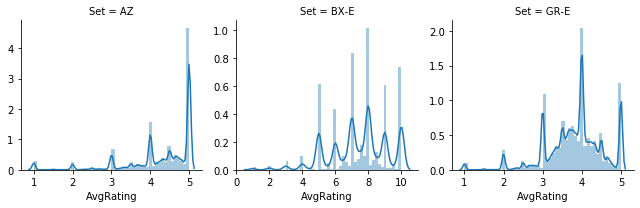

In [22]:
grid = sns.FacetGrid(col='Set', data=item_means, sharey=False, sharex=False)
grid.map(sns.distplot, 'AvgRating')

## Count and Integrate

Now that we have the data loaded, we need to do a few things:

1. Connect with gender info
2. Count books (or ratings) by gender. All kinds of unlinked gender are mapped to `unlinked`.
3. Integrate into a single set of lists

To start, we'll define a couple of helper for counting books or ratings:

In [23]:
def gender_info(books, full=False):
    # get gender info
    books = books.join(book_gender, on='item', how='left')
    # normalize things
    if full:
        books['gender'].cat.add_categories(['no-book'], inplace=True)
        books['gender'].fillna('no-book', inplace=True)
        books['gender'].cat.reorder_categories(['no-book', 'no-loc-author', 'no-viaf-author',
                                                'unknown', 'ambiguous', 'female', 'male'], inplace=True)
    else:
        books['gender'].cat.add_categories(['unlinked'], inplace=True)
        books['gender'].fillna('unlinked', inplace=True)
        books.loc[books['gender'] == 'no-loc-author', 'gender'] = 'unlinked'
        books.loc[books['gender'] == 'no-viaf-author', 'gender'] = 'unlinked'
        books['gender'].cat.remove_unused_categories(inplace=True)
        books['gender'].cat.reorder_categories(['female', 'male', 'ambiguous', 'unknown', 'unlinked'], inplace=True)
    return books

In [24]:
def summarize_by_gender(book_frame, full=False):
    # we only need the item column
    books = gender_info(book_frame[['item']], full)

    # join and count
    counts = books.groupby('gender').agg(['count', 'nunique']).droplevel(0, axis=1)
    counts = counts.rename(columns={'count': 'Ratings', 'nunique': 'Books'})
    return counts

Let's see the function in action:

In [25]:
summarize_by_gender(ratings['BX-E'])

,Ratings,Books
gender,,
female,138827,38093
male,185054,55906
ambiguous,30444,4014
unknown,27434,16900
unlinked,45524,36757


Now build up a full frame of everything:

In [26]:
eprint('summarizing LOC')
summaries = {'LOC': summarize_by_gender(loc_books)}
for ds, f in ratings.items():
    eprint('summarizing', ds)
    summaries[ds] = summarize_by_gender(f)
gender_stats = pd.concat(summaries, names=['DataSet'])
gender_stats.info()

summarizing LOC


summarizing AZ


summarizing BX-E


summarizing BX-I


summarizing GR-E


summarizing GR-I


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30 entries, ('LOC', 'female') to ('GR-I', 'unlinked')
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Ratings  30 non-null     int64
 1   Books    30 non-null     int64
dtypes: int64(2)
memory usage: 904.0+ bytes


In [27]:
eprint('summarizing LOC')
fsums = {'LOC': summarize_by_gender(loc_books, True)}
for ds, f in ratings.items():
    eprint('summarizing', ds)
    fsums[ds] = summarize_by_gender(f, True)
full_stats = pd.concat(fsums, names=['DataSet'])
full_stats.info()

summarizing LOC


summarizing AZ


summarizing BX-E


summarizing BX-I


summarizing GR-E


summarizing GR-I


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 42 entries, ('LOC', 'ambiguous') to ('GR-I', 'no-book')
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Ratings  42 non-null     int64
 1   Books    42 non-null     int64
dtypes: int64(2)
memory usage: 1.3+ KB


In [28]:
book_counts = full_stats['Books'].unstack()
book_counts = book_counts[['no-book', 'no-loc-author', 'no-viaf-author', 'unknown', 'ambiguous', 'male', 'female']]
book_counts

gender,no-book,no-loc-author,no-viaf-author,unknown,ambiguous,male,female
DataSet,,,,,,,
LOC,0,842755,297405,1214597,53232,2195117,664221
AZ,934847,226764,157072,236219,17056,480628,215556
BX-E,22674,6456,7627,16900,4014,55906,38093
BX-I,45560,12906,15631,34614,6770,96933,67087
GR-E,0,487495,35267,95887,11087,276045,174996
GR-I,0,495592,36106,97667,11189,279442,176640


In [29]:
book_counts[['no-book', 'no-loc-author', 'no-viaf-author']].sum(axis=1)

DataSet
LOC     1140160
AZ      1318683
BX-E      36757
BX-I      74097
GR-E     522762
GR-I     531698
dtype: int64

In [30]:
book_fracs = book_counts.divide(book_counts.sum(axis=1), axis=0)
book_fracs

gender,no-book,no-loc-author,no-viaf-author,unknown,ambiguous,male,female
DataSet,,,,,,,
LOC,0.000000,0.159997,0.056462,0.230591,0.010106,0.416742,0.126102
AZ,0.412164,0.099978,0.069251,0.104146,0.007520,0.211904,0.095036
BX-E,0.149496,0.042566,0.050287,0.111426,0.026465,0.368603,0.251157
BX-I,0.163005,0.046175,0.055925,0.123842,0.024222,0.346807,0.240024
GR-E,0.000000,0.451060,0.032631,0.088720,0.010258,0.255413,0.161917
GR-I,0.000000,0.451920,0.032924,0.089061,0.010203,0.254817,0.161074


In [31]:
# book_counts.divide(book_counts.sum(axis=1), axis=0) * 100

In [32]:
print((book_counts.divide(book_counts.sum(axis=1), axis=0) * 100).to_latex(float_format='%.1f%%'))

\begin{tabular}{lrrrrrrr}
\toprule
gender &  no-book &  no-loc-author &  no-viaf-author &  unknown &  ambiguous &  male &  female \\
DataSet &          &                &                 &          &            &       &         \\
\midrule
LOC     &     0.0\% &          16.0\% &            5.6\% &    23.1\% &       1.0\% & 41.7\% &   12.6\% \\
AZ      &    41.2\% &          10.0\% &            6.9\% &    10.4\% &       0.8\% & 21.2\% &    9.5\% \\
BX-E    &    14.9\% &           4.3\% &            5.0\% &    11.1\% &       2.6\% & 36.9\% &   25.1\% \\
BX-I    &    16.3\% &           4.6\% &            5.6\% &    12.4\% &       2.4\% & 34.7\% &   24.0\% \\
GR-E    &     0.0\% &          45.1\% &            3.3\% &     8.9\% &       1.0\% & 25.5\% &   16.2\% \\
GR-I    &     0.0\% &          45.2\% &            3.3\% &     8.9\% &       1.0\% & 25.5\% &   16.1\% \\
\bottomrule
\end{tabular}



To facilitate plotting, we need to do a few more transformations:

1. Shift into a tall format with a `Scope`
2. Convert counts to percents
3. Drop the LOC Ratings, because it is meaningless

In [33]:
gs_tall = pd.DataFrame({'Count': gender_stats.stack()})
gs_tall.index.rename(['DataSet', 'Gender', 'Scope'], inplace=True)
gs_tall = gs_tall.reorder_levels(['DataSet', 'Scope', 'Gender']).sort_index()
gs_tall['Fraction'] = gs_tall['Count'] / gs_tall.groupby(level=['DataSet', 'Scope'])['Count'].sum()
gs_tall.drop(('LOC', 'Ratings'), inplace=True)
gs_tall.sort_index(inplace=True)
gs_tall.reset_index(inplace=True)
gs_tall['Gender'].cat.rename_categories({
    'female': 'F',
    'male': 'M',
    'ambiguous': 'Amb.',
    'unknown': 'UnK',
    'unlinked': 'UnL'
}, inplace=True)
gs_tall['DataSet'] = gs_tall['DataSet'].astype('category')
gs_tall['DataSet'].cat.reorder_categories(['LOC', 'AZ', 'BX-I', 'BX-E', 'GR-I', 'GR-E'], inplace=True)
gs_tall

,DataSet,Scope,Gender,Count,Fraction
0,AZ,Books,F,215556,0.095036
1,AZ,Books,M,480628,0.211904
2,AZ,Books,Amb.,17056,0.007520
3,AZ,Books,UnK,236219,0.104146
4,AZ,Books,UnL,1318683,0.581393
5,AZ,Ratings,F,4313858,0.192064
6,AZ,Ratings,M,6557232,0.291945
7,AZ,Ratings,Amb.,535239,0.023830
8,AZ,Ratings,UnK,2069787,0.092152
9,AZ,Ratings,UnL,8984419,0.400009


Finally, we can plot it:

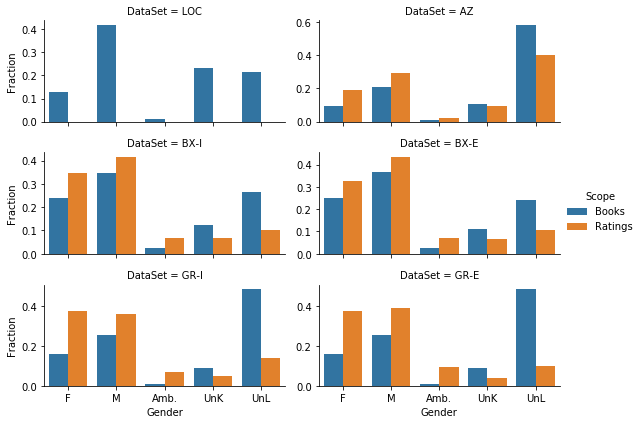

In [34]:
sns.catplot(x='Gender', y='Fraction', col='DataSet', col_wrap=2, hue='Scope',
            data=gs_tall.reset_index(),
            kind='bar', sharey=False, height=2, aspect=2)

Manual plotting logic for the paper:

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 7 x 4.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\link-stats.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


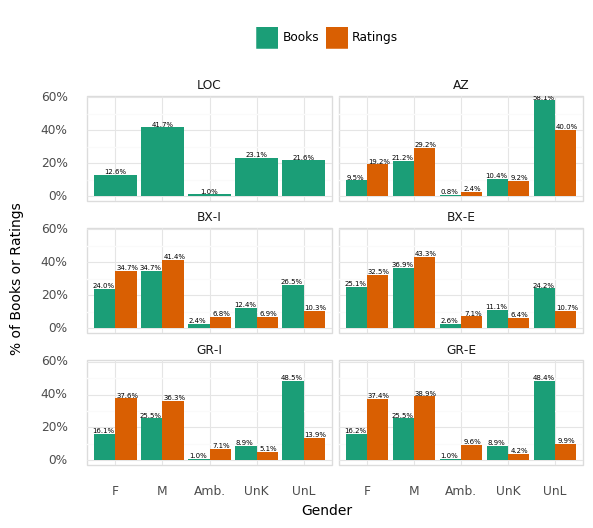

<ggplot: (-9223371858880154080)>

In [35]:
make_plot(gs_tall, p.aes('Gender', 'Fraction', fill='Scope'),
    p.geom_bar(stat='identity', position='dodge'),
    p.geom_text(p.aes(label='Fraction*100'), format_string='{:.1f}%', size=5, 
                position=p.position_dodge(width=1), va='bottom'),
    p.facet_wrap('~DataSet', ncol=2),
    p.scale_fill_brewer('qual', 'Dark2'),
    p.scale_y_continuous(labels=lbl_pct),
    p.ylab('% of Books or Ratings'),
    legend_position='top', legend_title=p.element_blank(),
    file='link-stats.pdf', width=7, height=4.5)

Known-gender books:

In [36]:
k_bc = book_counts[['male', 'female']]
k_bf = k_bc.divide(k_bc.sum(axis=1), axis=0)
k_bf = k_bf.loc[['LOC', 'AZ', 'BX-I', 'GR-I']]
k_bf

gender,male,female
DataSet,,
LOC,0.767701,0.232299
AZ,0.690375,0.309625
BX-I,0.590983,0.409017
GR-I,0.612701,0.387299


In [37]:
print((k_bf * 100).to_latex(float_format='%.1f%%'))

\begin{tabular}{lrr}
\toprule
gender &  male &  female \\
DataSet &       &         \\
\midrule
LOC     & 76.8\% &   23.2\% \\
AZ      & 69.0\% &   31.0\% \\
BX-I    & 59.1\% &   40.9\% \\
GR-I    & 61.3\% &   38.7\% \\
\bottomrule
\end{tabular}



In [38]:
k_bf.columns = k_bf.columns.astype('str')
k_bft = k_bf.reset_index().melt(id_vars='DataSet')
k_bft['gender'] = k_bft.gender.astype('category').cat.reorder_categories(['male', 'female'])
k_bft['DataSet'] = k_bft.DataSet.astype('category').cat.reorder_categories(['LOC', 'AZ', 'BX-I', 'GR-I'])

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 2.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\frac-known-books.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


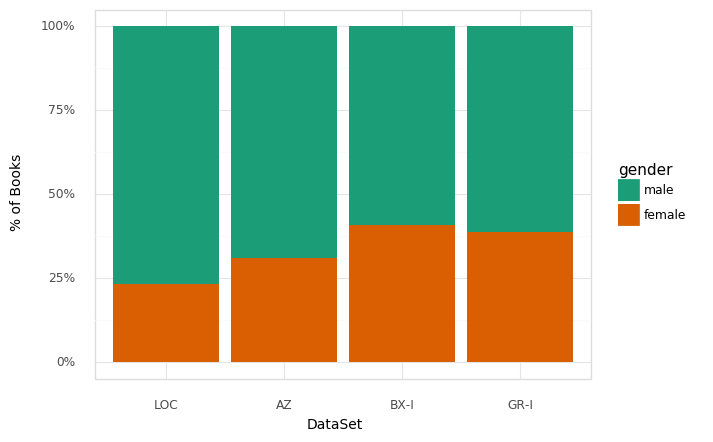

<ggplot: (-9223371858879291152)>

In [39]:
make_plot(k_bft, p.aes('DataSet', 'value', fill='gender'),
          p.geom_bar(stat='identity'),
          p.scale_fill_brewer('qual', 'Dark2'),
          p.ylab('% of Books'),
          p.scale_y_continuous(labels=lbl_pct),
          file='frac-known-books.pdf', width=4, height=2.5)

And do that again for ratings.

In [40]:
rate_counts = full_stats['Ratings'].unstack()
k_rc = rate_counts[['male', 'female']]
k_rf = k_rc.divide(k_rc.sum(axis=1), axis=0)
k_rf = k_rf.loc[datasets]
k_rf

gender,male,female
DataSet,,
AZ,0.603181,0.396819
BX-E,0.571364,0.428636
BX-I,0.544148,0.455852
GR-E,0.509770,0.490230
GR-I,0.490939,0.509061


In [41]:
all_cts = full_stats.reorder_levels([1,0]).loc[['male', 'female']].reorder_levels([1,0]).unstack()
all_cts.sort_index(axis=1, inplace=True)
print(all_cts.divide(all_cts.sum(axis=1, level=0), axis=0, level=0).to_latex(float_format=lambda f: '{:.1f}%'.format(f*100)))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Books} & \multicolumn{2}{l}{Ratings} \\
gender & female &  male &  female &  male \\
DataSet &        &       &         &       \\
\midrule
LOC     &  23.2\% & 76.8\% &   23.2\% & 76.8\% \\
AZ      &  31.0\% & 69.0\% &   39.7\% & 60.3\% \\
BX-E    &  40.5\% & 59.5\% &   42.9\% & 57.1\% \\
BX-I    &  40.9\% & 59.1\% &   45.6\% & 54.4\% \\
GR-E    &  38.8\% & 61.2\% &   49.0\% & 51.0\% \\
GR-I    &  38.7\% & 61.3\% &   50.9\% & 49.1\% \\
\bottomrule
\end{tabular}



In [42]:
k_rf.columns = k_rf.columns.astype('str')
k_rft = k_rf.reset_index().melt(id_vars='DataSet')
k_rft['gender'] = k_rft.gender.astype('category').cat.reorder_categories(['male', 'female'])
k_rft['DataSet'] = k_rft.DataSet.astype('category').cat.reorder_categories(datasets)

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 2.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\frac-known-rates.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


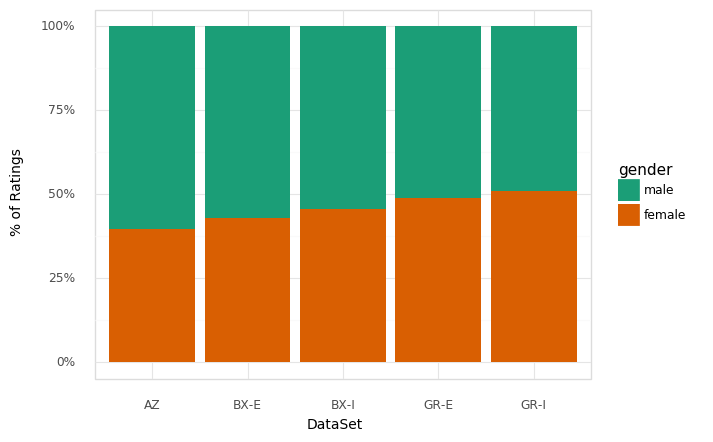

<ggplot: (-9223371858877696692)>

In [43]:
make_plot(k_rft, p.aes('DataSet', 'value', fill='gender'),
          p.geom_bar(stat='identity'),
          p.scale_fill_brewer('qual', 'Dark2'),
          p.scale_y_continuous(labels=lbl_pct),
          p.ylab('% of Ratings'),
          file='frac-known-rates.pdf', width=4, height=2.5)

## Popularity and Gender Distributions

We now want to look at popularity and assorted distributions.

We will start by computing item statistics.

In [44]:
def _ds_stats(ds, df):
    eprint('summarizing ', ds)
    stats = df.groupby('item').user.count().reset_index(name='nratings')
    stats = gender_info(stats)
    stats['PopRank'] = stats['nratings'].rank()
    stats['PopRank'] = stats['PopRank'] / stats['PopRank'].max()
    stats['PopQ'] = (stats['PopRank'] * 100 - 0.001).astype('i4')
    stats['Set'] = ds
    return stats
item_stats = pd.concat(_ds_stats(ds, df) for (ds, df) in ratings.items() if not ds.endswith('-E'))
item_stats['Set'] = item_stats['Set'].astype('category')
item_stats.head()

summarizing  AZ


summarizing  BX-I


summarizing  GR-I


,item,nratings,gender,PopRank,PopQ,Set
0,0,4,male,0.652857,65,AZ
1,2,65,male,0.977629,97,AZ
2,5,89,unlinked,0.984913,98,AZ
3,8,19,male,0.911341,91,AZ
4,11,32,male,0.948883,94,AZ


Compute rating count histograms:

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


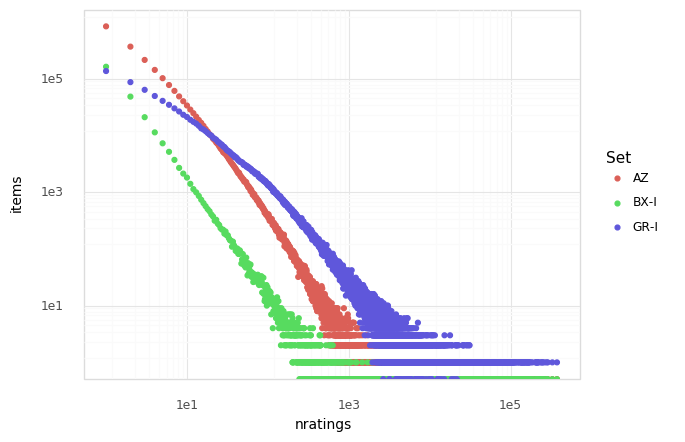

<ggplot: (-9223371858877655768)>

In [45]:
nr_hist = item_stats.groupby(['Set', 'nratings'])['item'].count().reset_index(name='items')
make_plot(nr_hist, p.aes(x='nratings', y='items', color='Set'),
          p.geom_point(),
          p.scale_x_log10(),
          p.scale_y_log10())

Let's look at rating count per book by gender resolution:

In [46]:
rate_rates = item_stats.groupby(['Set', 'gender'])['nratings'].agg(['mean', 'median'])
rr_stat = rate_rates.unstack().swaplevel(axis=1).loc[:, ['male', 'female']].sort_index(axis=1)
print(rr_stat.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
gender & \multicolumn{2}{l}{female} & \multicolumn{2}{l}{male} \\
{} &   mean & median &   mean & median \\
Set  &        &        &        &        \\
\midrule
AZ   &  20.01 &      4 &  13.64 &      3 \\
BX-I &   5.84 &      2 &   4.82 &      1 \\
GR-I & 402.35 &     34 & 245.28 &     20 \\
\bottomrule
\end{tabular}



Now compute gender histograms by percentile so we can stack:

In [47]:
pop_g = item_stats.groupby(['Set', 'PopQ', 'gender'], observed=True)['item'].count().unstack()
pop_g.fillna(0, inplace=True)
pop_g = pop_g.divide(pop_g.sum(axis=1), axis=0)
pop_g.sort_index(inplace=True)
pop_g.head()

gender        male  unlinked    female   unknown  ambiguous
Set PopQ                                                   
AZ  18    0.174433  0.667347  0.067153  0.085216   0.005852
    44    0.207661  0.593931  0.085052  0.106450   0.006905
    57    0.219571  0.567501  0.091894  0.114128   0.006906
    65    0.225784  0.554707  0.095220  0.116672   0.007617
    70    0.229021  0.542932  0.100422  0.120130   0.007495

Propagate to percentile 0:

In [48]:
for ds in pop_g.index.levels[0].categories:
    dspg = pop_g.loc[ds, :]
    pop_g.loc[(ds, 0), :] = dspg.iloc[0, :]
pop_g.sort_index(inplace=True)

Stack for plotting:

In [49]:
pop_g = pop_g.stack().reset_index(name='items')
pop_g.head()

,Set,PopQ,gender,items
0,AZ,0,male,0.174433
1,AZ,0,unlinked,0.667347
2,AZ,0,female,0.067153
3,AZ,0,unknown,0.085216
4,AZ,0,ambiguous,0.005852


And make an area plot.

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\gender-by-pop.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


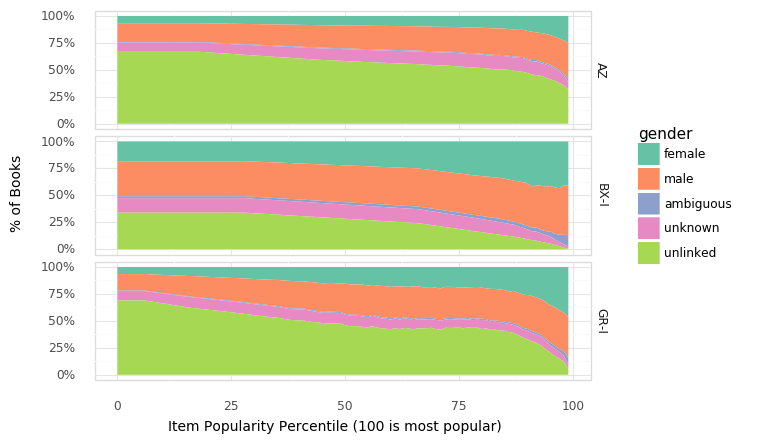

<ggplot: (-9223371858879844724)>

In [50]:
make_plot(pop_g, p.aes(x='PopQ', y='items', fill='gender'),
          p.geom_area(),
          p.scale_fill_brewer('qual', 'Set2'),
          p.facet_grid('Set ~'),
          p.xlab('Item Popularity Percentile (100 is most popular)'),
          p.ylab('% of Books'),
          p.scale_y_continuous(labels=lbl_pct),
          file='gender-by-pop.pdf', width=8, height=5)